## Notes from EDA

From exploritory data analysis I know that there are several continuous features that are more than moderately coorelated with the target variable. I also know that these features are also correlated with eachother. This presents the greatest challange for sucessfuly modeling this problem. Because of this I will begin with using some of sklearn's feature selection methods including recursive feature elimination and removal of features with low variance. Lasso Regression may also be an effective solution to the issue of many features which are either multicolinear or add mostly noise to the model. 

### Import libraries and define functions

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
import warnings
warnings.filterwarnings(action="ignore")

### Load the cleaned dataset

In [2]:
df = pd.read_csv('houseprices_cleaned.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1457 entries, 0 to 1456
Data columns (total 60 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   saleprice             1457 non-null   float64
 1   mssubclass            1457 non-null   object 
 2   mszoning              1457 non-null   object 
 3   lotarea               1457 non-null   float64
 4   street                1457 non-null   object 
 5   alley                 1457 non-null   object 
 6   lotshape              1457 non-null   object 
 7   landcontour           1457 non-null   object 
 8   utilities             1457 non-null   object 
 9   lotconfig             1457 non-null   object 
 10  landslope             1457 non-null   object 
 11  neighborhood          1457 non-null   object 
 12  condition1            1457 non-null   object 
 13  condition2            1457 non-null   object 
 14  bldgtype              1457 non-null   object 
 15  housestyle           

### Preprocessing

In [4]:
X = df.drop('saleprice', axis = 1)
y = df['saleprice']

In [5]:
# Encode the categorical
for col in X.select_dtypes(include='object').columns:
    X = pd.concat([X, pd.get_dummies(X[col], prefix=col)], axis=1)
    X.drop(col, axis=1, inplace=True)
    
    # Drop the dominant class or the most neutral class for each of the categorical variables

X.drop(['mssubclass_1_story_1946_forward'
         , 'mszoning_RL'
         , 'street_Pave'
         , 'alley_no_alley'
         , 'lotshape_Reg'
         , 'landcontour_Lvl'
         , 'utilities_AllPub'
         , 'lotconfig_Inside'
         , 'landslope_Gtl'
         , 'neighborhood_NAmes'
         , 'neighborhood_NPkVill'
         , 'condition1_Norm'
         , 'condition2_Norm'
         , 'condition2_PosA'
         , 'bldgtype_1Fam'
         , 'housestyle_1Story'
         , 'roofstyle_Gable'
         , 'roofmatl_CompShg'
         , 'exterior1st_VinylSd'
         , 'exterior2nd_VinylSd'
         , 'masvnrtype_None'
         , 'exterqual_TA'
         , 'extercond_TA'
         , 'foundation_PConc'
         , 'bsmtqual_TA'
         , 'bsmtexposure_Av'
         , 'bsmtfintype1_Unf'
         , 'bsmtfintype2_Unf'
         , 'heating_GasA'
         , 'heatingqc_TA'
         , 'centralair_N'
         , 'electrical_SBrkr'
         , 'kitchenqual_TA'
         , 'functional_Typ'
         , 'fireplacequ_TA'
         , 'garagetype_Attchd'
         , 'garagefinish_Unf'
         , 'garagequal_TA'
         , 'garagecond_TA'
         , 'paveddrive_Y'
         , 'poolqc_no_pool'
         , 'fence_no_fence'
         , 'saletype_WD'
         , 'salecondition_Normal'], axis=1, inplace=True)

### Feature Selection

In [6]:
threshold = VarianceThreshold(threshold=.1)
threshold.fit(X)
mask = threshold.get_support()
X = X.loc[:, mask].copy()

In [7]:
scaler = StandardScaler()

for col in X.columns:
    X[col] = scaler.fit_transform(X[col].values.reshape(-1,1)) 

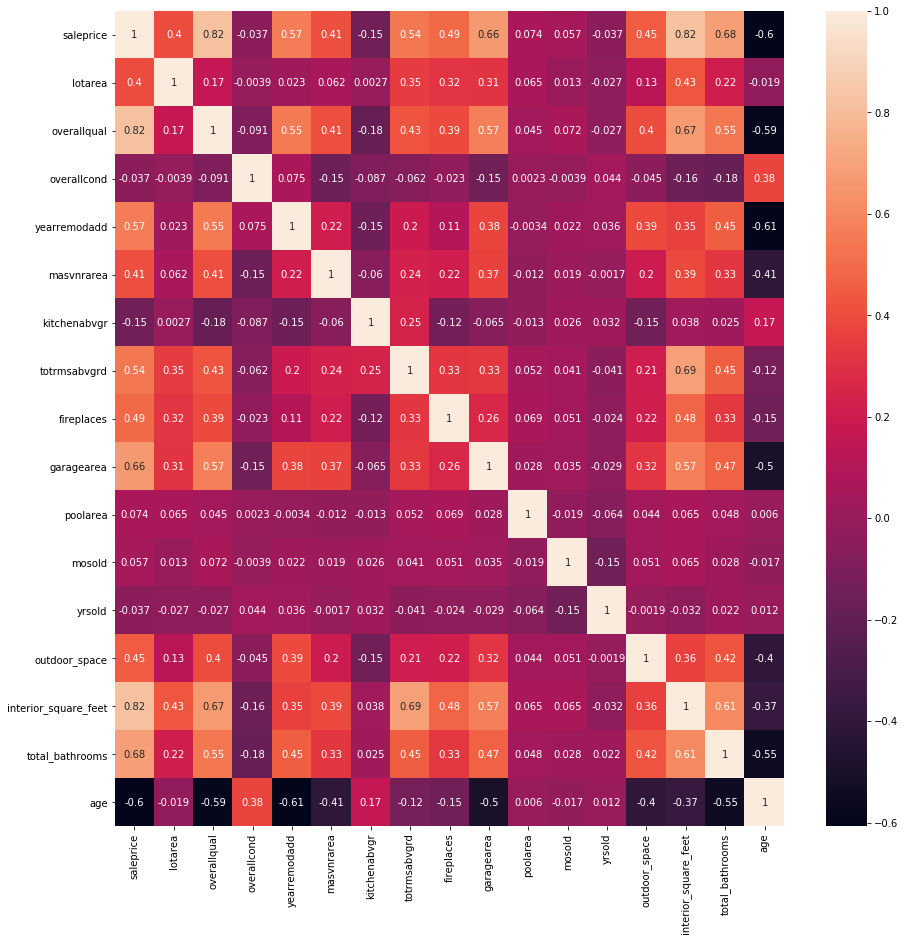

In [26]:
# Revisit the heatmap because multicolinearity is a big challange in this dataset

plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), annot=True)

In [11]:
X.columns

Index(['lotarea', 'overallqual', 'overallcond', 'yearremodadd', 'masvnrarea',
       'totrmsabvgrd', 'fireplaces', 'garagearea', 'poolarea', 'mosold',
       'yrsold', 'outdoor_space', 'interior_square_feet', 'total_bathrooms',
       'age', 'mssubclass_2_story_1946_forward', 'mszoning_RM', 'lotshape_IR1',
       'lotconfig_Corner', 'housestyle_2Story', 'roofstyle_Hip',
       'exterior1st_HdBoard', 'exterior1st_MetalSd', 'exterior1st_Wd Sdng',
       'exterior2nd_HdBoard', 'exterior2nd_MetalSd', 'exterior2nd_Wd Sdng',
       'masvnrtype_BrkFace', 'exterqual_Gd', 'foundation_CBlock',
       'bsmtqual_Gd', 'bsmtexposure_No', 'bsmtfintype1_ALQ',
       'bsmtfintype1_GLQ', 'heatingqc_Ex', 'heatingqc_Gd', 'kitchenqual_Gd',
       'fireplacequ_Gd', 'fireplacequ_no_fireplace', 'garagetype_Detchd',
       'garagefinish_Fin', 'garagefinish_RFn'],
      dtype='object')

In [13]:
# Removing only overall quality because of colinearity
features_1 = ['lotarea', 'overallcond', 'yearremodadd', 'masvnrarea',
       'totrmsabvgrd', 'fireplaces', 'garagearea', 'poolarea', 'mosold',
       'yrsold', 'outdoor_space', 'interior_square_feet', 'total_bathrooms',
       'age', 'mssubclass_2_story_1946_forward', 'mszoning_RM', 'lotshape_IR1',
       'lotconfig_Corner', 'housestyle_2Story', 'roofstyle_Hip',
       'exterior1st_HdBoard', 'exterior1st_MetalSd', 'exterior1st_Wd Sdng',
       'exterior2nd_HdBoard', 'exterior2nd_MetalSd', 'exterior2nd_Wd Sdng',
       'masvnrtype_BrkFace', 'exterqual_Gd', 'foundation_CBlock',
       'bsmtqual_Gd', 'bsmtexposure_No', 'bsmtfintype1_ALQ',
       'bsmtfintype1_GLQ', 'heatingqc_Ex', 'heatingqc_Gd', 'kitchenqual_Gd',
       'fireplacequ_Gd', 'fireplacequ_no_fireplace', 'garagetype_Detchd',
       'garagefinish_Fin', 'garagefinish_RFn']

### Modeling

In [14]:
X_temp = X[features_1].copy()
X_temp =sm.add_constant(X_temp)

X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=.5, random_state=1312)

results_1 = sm.OLS(y_train, X_train).fit()

results_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     138.2
Date:                Tue, 20 Oct 2020   Prob (F-statistic):          2.88e-301
Time:                        23:55:22   Log-Likelihood:                 429.41
No. Observations:                 728   AIC:                            -774.8
Df Residuals:                     686   BIC:                            -582.0
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              12.0265      0.005   2301.174      0.000      12.016      12.037
lotarea                             0.0493      0.007      6.609      0.000       0.035       0.064
overallcond                         0.0849      0.007     12.387      0.000       0.071       0.098
yearremodadd                        0.0250      0.008      3.084      0.002       0.009       0.041
masvnrarea                          0.0167      0.010      1.673      0.095      -0.003       0.036
totrmsabvgrd                       -0.0068      0.009     -0.788      0.431      -0.024       0.010
fireplaces                          0.0539      0.013      4.275      0.000       0.029       0.079
garagearea                          0.0411      0.008      5.343      0.000       0.026       0.056
poolarea                            0.0147      0.004      3.670      0.000       0.007       0.023
mosold                              0.0023      0.005      0.449      0.653      -0.008       0.013
yrsold                             -0.0061      0.005     -1.160      0.247      -0.016       0.004
outdoor_space                       0.0040      0.006      0.627      0.531      -0.008       0.016
interior_square_feet                0.1725      0.010     17.018      0.000       0.153       0.192
total_bathrooms                     0.0281      0.008      3.359      0.001       0.012       0.044
age                                -0.1253      0.011    -10.930      0.000      -0.148      -0.103
mssubclass_2_story_1946_forward    -0.0076      0.010     -0.802      0.423      -0.026       0.011
mszoning_RM                        -0.0181      0.007     -2.752      0.006      -0.031      -0.005
lotshape_IR1                        0.0004      0.006      0.077      0.938      -0.011       0.011
lotconfig_Corner                    0.0006      0.005      0.118      0.906      -0.010       0.011
housestyle_2Story                   0.0267      0.009      2.914      0.004       0.009       0.045
roofstyle_Hip                       0.0195      0.006      3.299      0.001       0.008       0.031
exterior1st_HdBoard                 0.0140      0.012      1.183      0.237      -0.009       0.037
exterior1st_MetalSd                -0.0007      0.026     -0.027      0.979      -0.052       0.051
exterior1st_Wd Sdng                 0.0032      0.010      0.309      0.757      -0.017       0.024
exterior2nd_HdBoard                -0.0063      0.011     -0.556      0.578      -0.029       0.016
exterior2nd_MetalSd                 0.0138      0.026      0.531      0.596      -0.037       0.065
exterior2nd_Wd Sdng                 0.0164      0.011      1.560      0.119      -0.004       0.037
masvnrtype_BrkFace                 -0.0212      0.009     -2.369      0.018      -0

In [18]:
# Remove interior square feet instead

features_2 = ['lotarea', 'overallqual', 'overallcond', 'yearremodadd', 'masvnrarea',
       'totrmsabvgrd', 'fireplaces', 'garagearea', 'poolarea', 'mosold',
       'yrsold', 'outdoor_space', 'total_bathrooms',
       'age', 'mssubclass_2_story_1946_forward', 'mszoning_RM', 'lotshape_IR1',
       'lotconfig_Corner', 'housestyle_2Story', 'roofstyle_Hip',
       'exterior1st_HdBoard', 'exterior1st_MetalSd', 'exterior1st_Wd Sdng',
       'exterior2nd_HdBoard', 'exterior2nd_MetalSd', 'exterior2nd_Wd Sdng',
       'masvnrtype_BrkFace', 'exterqual_Gd', 'foundation_CBlock',
       'bsmtqual_Gd', 'bsmtexposure_No', 'bsmtfintype1_ALQ',
       'bsmtfintype1_GLQ', 'heatingqc_Ex', 'heatingqc_Gd', 'kitchenqual_Gd',
       'fireplacequ_Gd', 'fireplacequ_no_fireplace', 'garagetype_Detchd',
       'garagefinish_Fin', 'garagefinish_RFn']

In [19]:
X_temp = X[features_2].copy()
X_temp =sm.add_constant(X_temp)

X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=.5, random_state=1312)

results_2 = sm.OLS(y_train, X_train).fit()

results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     128.9
Date:                Tue, 20 Oct 2020   Prob (F-statistic):          3.56e-292
Time:                        23:57:33   Log-Likelihood:                 407.04
No. Observations:                 728   AIC:                            -730.1
Df Residuals:                     686   BIC:                            -537.3
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              12.0291      0.005   2233.254      0.000      12.018      12.040
lotarea                             0.0677      0.008      8.923      0.000       0.053       0.083
overallqual                         0.1392      0.009     15.213      0.000       0.121       0.157
overallcond                         0.0599      0.007      8.375      0.000       0.046       0.074
yearremodadd                        0.0231      0.008      2.763      0.006       0.007       0.040
masvnrarea                          0.0164      0.010      1.586      0.113      -0.004       0.037
totrmsabvgrd                        0.0557      0.008      7.405      0.000       0.041       0.070
fireplaces                          0.0531      0.013      4.068      0.000       0.027       0.079
garagearea                          0.0549      0.008      7.059      0.000       0.040       0.070
poolarea                            0.0110      0.004      2.665      0.008       0.003       0.019
mosold                              0.0023      0.005      0.425      0.671      -0.008       0.013
yrsold                             -0.0028      0.005     -0.507      0.612      -0.013       0.008
outdoor_space                       0.0105      0.007      1.612      0.107      -0.002       0.023
total_bathrooms                     0.0530      0.008      6.250      0.000       0.036       0.070
age                                -0.0785      0.012     -6.476      0.000      -0.102      -0.055
mssubclass_2_story_1946_forward    -0.0173      0.010     -1.774      0.077      -0.036       0.002
mszoning_RM                        -0.0178      0.007     -2.626      0.009      -0.031      -0.004
lotshape_IR1                        0.0081      0.006      1.413      0.158      -0.003       0.019
lotconfig_Corner                    0.0064      0.005      1.207      0.228      -0.004       0.017
housestyle_2Story                   0.0049      0.010      0.511      0.610      -0.014       0.024
roofstyle_Hip                       0.0211      0.006      3.471      0.001       0.009       0.033
exterior1st_HdBoard                -0.0061      0.012     -0.501      0.616      -0.030       0.018
exterior1st_MetalSd                -0.0248      0.027     -0.913      0.361      -0.078       0.028
exterior1st_Wd Sdng                -0.0172      0.011     -1.599      0.110      -0.038       0.004
exterior2nd_HdBoard                 0.0052      0.012      0.444      0.657      -0.018       0.028
exterior2nd_MetalSd                 0.0347      0.027      1.290      0.198      -0.018       0.087
exterior2nd_Wd Sdng                 0.0268      0.011      2.480      0.013       0.006       0.048
masvnrtype_BrkFace                 -0.0234      0.009     -2.534      0.011      -0

In [20]:
# What about using all of the features?
X_temp = X.copy()
X_temp =sm.add_constant(X_temp)

X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=.5, random_state=1312)

results_3 = sm.OLS(y_train, X_train).fit()

results_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     166.9
Date:                Wed, 21 Oct 2020   Prob (F-statistic):               0.00
Time:                        00:00:15   Log-Likelihood:                 499.72
No. Observations:                 728   AIC:                            -913.4
Df Residuals:                     685   BIC:                            -716.1
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              12.0268      0.005   2532.673      0.000      12.017      12.036
lotarea                             0.0519      0.007      7.654      0.000       0.039       0.065
overallqual                         0.1024      0.008     12.081      0.000       0.086       0.119
overallcond                         0.0702      0.006     11.067      0.000       0.058       0.083
yearremodadd                        0.0176      0.007      2.381      0.018       0.003       0.032
masvnrarea                          0.0060      0.009      0.661      0.509      -0.012       0.024
totrmsabvgrd                       -0.0027      0.008     -0.342      0.733      -0.018       0.013
fireplaces                          0.0358      0.012      3.094      0.002       0.013       0.058
garagearea                          0.0336      0.007      4.797      0.000       0.020       0.047
poolarea                            0.0116      0.004      3.187      0.002       0.004       0.019
mosold                              0.0012      0.005      0.246      0.806      -0.008       0.010
yrsold                             -0.0031      0.005     -0.638      0.523      -0.013       0.006
outdoor_space                       0.0018      0.006      0.306      0.760      -0.010       0.013
interior_square_feet                0.1364      0.010     14.094      0.000       0.117       0.155
total_bathrooms                     0.0332      0.008      4.365      0.000       0.018       0.048
age                                -0.0938      0.011     -8.736      0.000      -0.115      -0.073
mssubclass_2_story_1946_forward    -0.0032      0.009     -0.372      0.710      -0.020       0.014
mszoning_RM                        -0.0210      0.006     -3.507      0.000      -0.033      -0.009
lotshape_IR1                        0.0028      0.005      0.551      0.582      -0.007       0.013
lotconfig_Corner                    0.0020      0.005      0.427      0.670      -0.007       0.011
housestyle_2Story                   0.0145      0.008      1.720      0.086      -0.002       0.031
roofstyle_Hip                       0.0118      0.005      2.182      0.029       0.001       0.022
exterior1st_HdBoard                 0.0044      0.011      0.411      0.681      -0.017       0.026
exterior1st_MetalSd                -0.0215      0.024     -0.900      0.368      -0.068       0.025
exterior1st_Wd Sdng                -0.0071      0.010     -0.742      0.458      -0.026       0.012
exterior2nd_HdBoard                -0.0026      0.010     -0.255      0.799      -0.023       0.018
exterior2nd_MetalSd                 0.0297      0.024      1.255      0.210      -0.017       0.076
exterior2nd_Wd Sdng                 0.0168      0.010      1.760      0.079      -0

The third model seems to be the best. Despite correlated features. Perhaps the scaling had some effect on the correlation of the features? For now I will proceed with all of the features and perhaps re-evaluate if there are performance problems. 

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=1312)

#### OLS

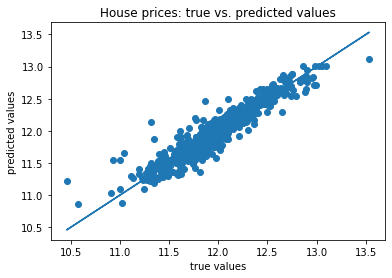

R-squared for the training set is: 0.9109655573670812
Mean absolute error of the prediction is: 0.09425584049358075
Mean squared error of the prediction is: 0.017512532065680583
Root mean squared error of the prediction is: 0.1323349238322242
Mean absolute percentage error of the prediction is: 0.7906852246294381


In [38]:
lrm = LinearRegression()
lrm.fit(X_train, y_train)

y_preds = lrm.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test)
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("House prices: true vs. predicted values")
plt.show()

print('R-squared for the training set is: {}'.format(lrm.score(X_train, y_train)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

#### Ridge

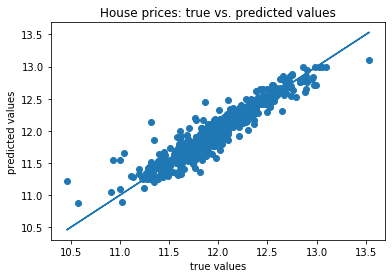

Best alpha value is : 10.0
R-squared for the training set is: 0.9108091914866968
Mean absolute error of the prediction is: 0.0937200762082805
Mean squared error of the prediction is: 0.017347153729735894
Root mean squared error of the prediction is: 0.13170859398587434
Mean absolute percentage error of the prediction is: 0.7861835257732595


In [39]:
ridge = RidgeCV()
ridge.fit(X_train, y_train)

y_preds = ridge.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test)
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("House prices: true vs. predicted values")
plt.show()

print('Best alpha value is : {}'.format(ridge.alpha_))
print('R-squared for the training set is: {}'.format(ridge.score(X_train, y_train)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

#### Lasso

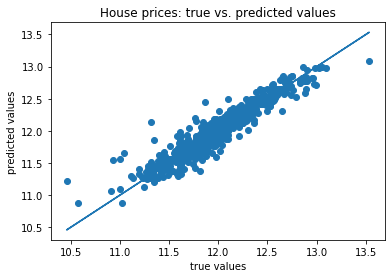

Best alpha value is : 0.0015682876420677924
R-squared for the training set is: 0.9100759540534841
Mean absolute error of the prediction is: 0.09328611156100566
Mean squared error of the prediction is: 0.01719299153110743
Root mean squared error of the prediction is: 0.13112204822648033
Mean absolute percentage error of the prediction is: 0.7825625320630019


In [40]:
lasso = LassoCV()
lasso.fit(X_train, y_train)

y_preds = lasso.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test)
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("House prices: true vs. predicted values")
plt.show()

print('Best alpha value is : {}'.format(lasso.alpha_))
print('R-squared for the training set is: {}'.format(lasso.score(X_train, y_train)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

#### Boosting
#### Ada Boosted Lasso

In [32]:
lasso = Lasso(alpha=.00157)

In [34]:
ada = AdaBoostRegressor(base_estimator=lasso, n_estimators=50, learning_rate=1.0, loss='linear')

In [35]:
ada.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=Lasso(alpha=0.00157, copy_X=True,
                                       fit_intercept=True, max_iter=1000,
                                       normalize=False, positive=False,
                                       precompute=False, random_state=None,
                                       selection='cyclic', tol=0.0001,
                                       warm_start=False),
                  learning_rate=1.0, loss='linear', n_estimators=50,
                  random_state=None)

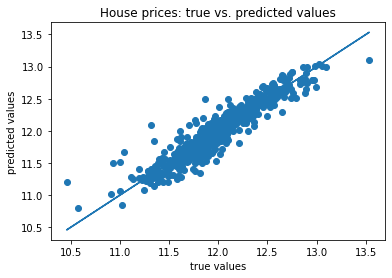

R-squared for the training set is: 0.9030843583687365
Mean absolute error of the prediction is: 0.10065739416297627
Mean squared error of the prediction is: 0.019434817227476343
Root mean squared error of the prediction is: 0.13940881330631985
Mean absolute percentage error of the prediction is: 0.8433533474100228


In [41]:
y_preds = ada.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test)
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("House prices: true vs. predicted values")
plt.show()


print('R-squared for the training set is: {}'.format(ada.score(X_train, y_train)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

#### Gradient Boosting

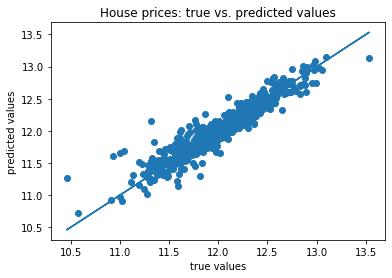

R-squared for the training set is: 0.9647754759390349
Mean absolute error of the prediction is: 0.0900563767908567
Mean squared error of the prediction is: 0.01718401978579943
Root mean squared error of the prediction is: 0.1310878323331324
Mean absolute percentage error of the prediction is: 0.7560089977815442


In [42]:
grad = GradientBoostingRegressor()
grad.fit(X_train, y_train)

y_preds = grad.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test)
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("House prices: true vs. predicted values")
plt.show()


print('R-squared for the training set is: {}'.format(grad.score(X_train, y_train)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

### Model Tuning
The gradient boosted model performed the best on both R-squared and MAPE. Time to tune it.

In [52]:
train_scores = []
test_scores = []
estimators = np.arange(1, 1000, 100)

for val in estimators:
    grad = GradientBoostingRegressor(n_estimators=val)
    grad.fit(X_train, y_train)
    
    train_scores.append(grad.score(X_train, y_train))
    test_scores.append(grad.score(X_test, y_test))

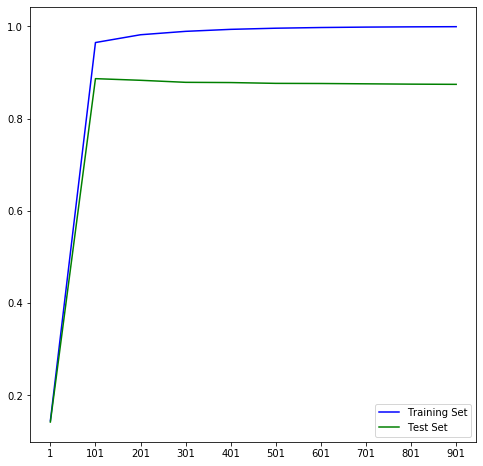

In [54]:
plt.figure(figsize=(8,8))
plt.plot(estimators, train_scores, color='blue', label='Training Set')
plt.plot(estimators, test_scores, color='green', label='Test Set')
plt.xticks(np.arange(1, 1000, 100))
plt.legend()

## Conclusion

Gradient boosted least squares, which is the default solver for sklearn's GradiendBoostedRegressor package. The default number of estimators is 100, which is also the value indicated by tuning. Thus this package worked out of the box to produce the best results of the models tried. 